# Understanding the relationship between nonlinear contrast optimization and the shape and size of the focal-plane dark hole.

## Description:
In this notebook we generate a static phasescreen, calculate the gradients of the contrast w.r.t. the DM actuators using TensorFlow, and use a gradient descent based optimizer to optimize for contrast. We use various APP coronagraphs to generate different dark holes and then activel control the contrast within the dark hole using the AO system.

### Step 1: Installing hcipy on Colab.

In [ ]:
!pip uninstall hcipy
!rm -rf hcipy
!git clone https://github.com/ehpor/hcipy.git
!cd hcipy; git pull
!cd hcipy; python setup.py install

### Step 2: Importing necessary libraries and setting up optical system.

In [1]:
## Necessary imports
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
import time
from scipy.optimize import minimize

In [2]:
## Create aperture and pupil/focal grids
wavelength = 532e-9
N = 512
D = 10.5e-3
pupil_grid = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(8, 20, wavelength/D)
aperture = circular_aperture(D)

# Telescope parameters
Dtel=4
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)

## Create the deformable mirror
num_actuators = 35
actuator_spacing = D * 1.1 / num_actuators
xinetics_basis = make_xinetics_influence_functions(pupil_grid, num_actuators, actuator_spacing)
dm = DeformableMirror(xinetics_basis)
num_modes = len(dm.influence_functions)
dm.flatten()

## Tweeter DM
num_actuators = 25
actuator_spacing = D * 1.1 / num_actuators
xinetics_basis = make_xinetics_influence_functions(pupil_grid, num_actuators, actuator_spacing)
dm2 = DeformableMirror(xinetics_basis)
num_modes = len(dm2.influence_functions)
dm2.flatten()

# Atmosphere parameters
pixels_per_frame = 1
velocity = np.array([pixels_per_frame,0])
L0 = 40
r0 = 0.2
height = 0

# Make atmosphere
np.random.seed(19900305)
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity * tel_pupil_grid.delta[0], height, 2)
layer2 = ModalAdaptiveOpticsLayer(layer, dm.influence_functions, 0)
layers.append(layer2)
atmosphere = MultiLayerAtmosphere(layers, False)

## Create a demagnifier
mag = Magnifier(10.5e-3/4)

# Make initial phasescreen
wf_tel = Wavefront(tel_aperture(tel_pupil_grid), wavelength)
wf_tel.total_power = 100000
wf = mag.forward(wf_tel)

## Create propagator from pupil to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid)

## Create a known phase diversity aberration
num_div_coeffs = 5
div_coeffs = np.zeros(num_div_coeffs)
div_zernike_basis = make_zernike_basis(num_div_coeffs, D, pupil_grid, 2)
div_coeffs[2] = 1
diversity_phase = np.dot(div_zernike_basis.transformation_matrix, div_coeffs)
diversity = Apodizer(np.exp(1j * diversity_phase))

## Create detector
science_camera = NoiselessDetector()
diversity_camera = NoiselessDetector()

## Create a spatial filter to simulate WFS
filt_aperture = circular_aperture(35)
spatial_filter = Apodizer(filt_aperture(science_focal_grid))

## Generate a diffraction limited image for metrics
diff_lim_img = prop(wf).power

## Get the unit lambda/D
l_D = wavelength / D
plot_grid = make_focal_grid(8, 20, 1)

# Create an estimate of the NCP aberration for the forward model
ncp_field_est = np.exp(1j * np.zeros(wf.phase.shape))

We will use 5 different APP patterns:
1. A 2x2 l/D rectangular dark hole
2. A 4x4 l/D rectangular dark hole
3. A 6x6 l/D rectangular dark hole
4. A small semi-circular dark hole
5. A large semi-circular dark hole

In [3]:
app_design = 3

if app_design == 1:
    dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                      (diff_lim_img.grid.x < (4 * l_D)) &\
                      (diff_lim_img.grid.y >= (-1 * l_D)) &\
                      (diff_lim_img.grid.y < (1 * l_D)))
    dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (4 * l_D)) * (diff_lim_img.grid.y >= (-1 * l_D)) * (diff_lim_img.grid.y < (1 * l_D))).astype(float)

elif app_design == 2:
        dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                          (diff_lim_img.grid.x < (6 * l_D)) &\
                          (diff_lim_img.grid.y >= (-2 * l_D)) &\
                          (diff_lim_img.grid.y < (2 * l_D)))
        dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (6 * l_D)) * (diff_lim_img.grid.y >= (-2 * l_D)) * (diff_lim_img.grid.y < (2 * l_D))).astype(float)

elif app_design == 3:
        dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                          (diff_lim_img.grid.x < (8 * l_D)) &\
                          (diff_lim_img.grid.y >= (-3 * l_D)) &\
                          (diff_lim_img.grid.y < (3 * l_D)))
        dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (8 * l_D)) * (diff_lim_img.grid.y >= (-3 * l_D)) * (diff_lim_img.grid.y < (3 * l_D))).astype(float)

elif app_design == 4:
        dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                          (diff_lim_img.grid.x < (10 * l_D)) &\
                          (diff_lim_img.grid.y >= (-4 * l_D)) &\
                          (diff_lim_img.grid.y < (4 * l_D)))
        dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (10 * l_D)) * (diff_lim_img.grid.y >= (-4 * l_D)) * (diff_lim_img.grid.y < (4 * l_D))).astype(float)
        
elif app_design == 5:
        dz_ind = np.where((diff_lim_img.grid.x >= (2 * l_D)) &\
                          (diff_lim_img.grid.x < (12 * l_D)) &\
                          (diff_lim_img.grid.y >= (-5 * l_D)) &\
                          (diff_lim_img.grid.y < (5 * l_D)))
        dh_mask = ((diff_lim_img.grid.x >= (2 * l_D)) * (diff_lim_img.grid.x < (12 * l_D)) * (diff_lim_img.grid.y >= (-5 * l_D)) * (diff_lim_img.grid.y < (5 * l_D))).astype(float)

elif app_design == 6:
        dz_ind = (circular_aperture(16 * l_D)(science_focal_grid)).astype(bool)*(science_focal_grid.x > (2 * l_D))
        dh_mask = np.asarray(dz_ind.astype(int))
        
elif app_design == 7:
        dz_ind = (circular_aperture(30 * l_D)(science_focal_grid)).astype(bool)*(science_focal_grid.x > (2 * l_D))
        dh_mask = np.asarray(dz_ind.astype(int))
        
# Setting up the vAPP calculation parameters.
contrast_level = 1e-5
contrast_map = science_focal_grid.ones()
contrast_map[dz_ind] = contrast_level
num_iterations = 80

# Generate the vAPP pattern.
vAPP = generate_app_keller(wf, prop, contrast_map, num_iterations, beta = 1)
app_amp = vAPP.amplitude / vAPP.amplitude.max()
app_phase = vAPP.phase

app = Apodizer(app_amp * np.exp(1j * app_phase))

In [4]:
inverse_tm = inverse_tikhonov(dm2.influence_functions.transformation_matrix.toarray(), rcond=1e-4)

In [5]:
# Reset atmosphere
np.random.seed(19900305)
atmosphere.evolve_until(None)
# Make sure lag is accounted for
for loop in np.arange(0.001, 0.1, 0.001):
    atmosphere.evolve_until(loop)

atmosphere.t += 1
wfatms_tel = atmosphere.forward(wf_tel)
wfatms = mag.forward(wfatms_tel)

dm.flatten()

dm2.flatten()

flat_img = prop(app.forward(dm2.forward(wfatms))).power
flat_strehl = flat_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
flat_contrast = flat_img[dz_ind].mean() / flat_img[np.argmax(diff_lim_img)]

In [6]:
meters_to_rads = (2 * np.pi) / wavelength
x = np.linspace(-1.1,1.1,25)
XX, YY = np.meshgrid(x,-1*x)
r_grid = np.sqrt(XX**2+YY**2)
mask = (r_grid<=1.2).ravel()

Text(0.5, 1.0, 'PSF \nStrehl=0.6599\nContrast= 5.4009E-06')

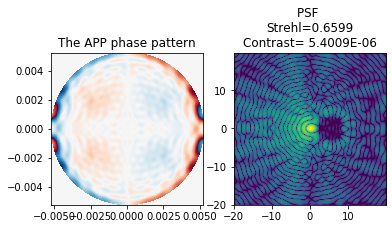

In [7]:
imapp = prop(app.forward(wf)).power

app_strehl = imapp[np.argmax(diff_lim_img)] / diff_lim_img.max()
app_contrast = imapp[dz_ind].mean() / imapp[np.argmax(diff_lim_img)]

plt.subplot(1, 2, 1)
imshow_field(app_phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.title('The APP phase pattern')
plt.subplot(1, 2, 2)
imshow_field(np.log10(imapp / imapp.max()), vmin=-6, grid=plot_grid)
plt.title("PSF \nStrehl={0:.4f}\nContrast= {1:.4E}".format(app_strehl, app_contrast))

### Step 3: Setting up the virtual model in TensorFlow.

In [ ]:
import tensorflow as tf

In [ ]:
@tf.function
def fraunhofer_tf(M1, M2, weights, wavelength, field):
    f = tf.reshape(field * tf.cast(weights, tf.complex128), (M1.shape[1], M2.shape[0]))
    result = -1j * tf.matmul(M1, tf.matmul(f, M2)) / wavelength
    return tf.reshape(result, [-1])

In [ ]:
@tf.function
def contrast_metric(x, D, coron, ncp_field, dh_mask, cent_ind, E_in, wavelength, M1, M2, weights):
    '''Function to calculate the gradient of the contrast w.r.t. the DM actuators.
    x: Tensor variable with actuator values of the DM.
    D: Influence functions of the DM.
    coron: Electric field contribution from the coronagraph optics.
    ncp: Electric field contribution from non common path aberrations.
    dh_ind: Dark hole mask in the focal plane where contrast is evaluated.
    cent_ind: Central bright pixel indices in the focal plane used to evaluate contrast.
    E_in: Placeholder for the incident electric field being propagated through the optics.
    wavelength: Wavelength of the incident wavefront'''
  
    # Use the DM influence functions and actuator levels to determine the surface
    S = tf.linalg.matvec(D, x, name="dm_surface")
  
    # Calculate the electric field contribution from the DM
    dm_field = tf.exp(2j * (2 * np.pi / wavelength) * tf.cast(S, tf.complex128), name="dm_field")
    E_d = tf.math.multiply(E_in, dm_field, name="E_d")
  
    # Calculate the electric field contribution from the NCPA
    E_ncp = tf.math.multiply(E_d, ncp_field, name="E_ncp")
  
    # Calculate the electric field contribution from the coronagraph
    E_c = tf.math.multiply(E_ncp, coron, name="E_c")
  
    # Fraunhofer propagate the electric field to the focal plane
    E_f = fraunhofer_tf(M1, M2, weights, wavelength, E_c)
  
    # Calculate the focal plane intensity
    I_f = tf.square(tf.abs(E_f), name="I_f")
  
    # Extract the intensities from pixels at the dark hole and at the center
    dh_intens = tf.divide(tf.math.reduce_sum(tf.math.multiply(I_f, dh_mask)), tf.math.reduce_sum(dh_mask))
    cent_intens = I_f[cent_ind]
  
    # Calculate the average raw contrast in the dark hole
    contrast = tf.math.divide(dh_intens, cent_intens, name='contrast')
                      
    return contrast

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-9)

In [ ]:
# Constants needed for the contrast calculation
uv_grid = science_focal_grid.scaled(2 * np.pi/ wavelength)
M1 = tf.convert_to_tensor(np.exp(-1j * np.outer(uv_grid.separated_coords[1], pupil_grid.separated_coords[1])))
M2 = tf.convert_to_tensor(np.exp(-1j * np.outer(uv_grid.separated_coords[0], pupil_grid.separated_coords[0])).T)
weights = tf.convert_to_tensor(pupil_grid.weights, dtype=tf.float64)
dm_mat = dm2.influence_functions.transformation_matrix.toarray()
D = tf.constant(dm_mat, name="inf_mat", dtype=tf.float64)
app_field = app_amp * np.exp(1j * app_phase)
coron = tf.constant(app_field, dtype=tf.complex128, name="coron")
ncp_tensor = tf.convert_to_tensor(ncp_field_est, dtype=tf.complex128)
dh_mask_tensor = tf.convert_to_tensor(dh_mask, tf.float64)
cent_ind = science_focal_grid.closest_to([0, 0])

### Optimize using gradient descent

In [ ]:
actuators = tf.Variable(dm2.actuators.copy(), dtype=tf.float64)

dm_wf = dm.forward(wfatms)
wf_to_optimize = dm_wf.copy()

E_in = tf.convert_to_tensor(wf_to_optimize.electric_field, dtype=tf.complex128)

strehl_evol = []
contrast_evol = []

for step in range(320):

    with tf.GradientTape() as tape:
        tape.watch(actuators)
        contrast_tf = contrast_metric(actuators, D, coron, ncp_tensor, dh_mask_tensor, cent_ind, E_in, wf.wavelength, M1, M2, weights)

    act_grads = tape.gradient(contrast_tf, [actuators])
    opt_step = optimizer.apply_gradients(zip(act_grads, [actuators]))

    dm2.actuators = actuators.numpy().copy()
    
    instant_img = prop(app.forward(dm2.forward(wfatms))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
    
    strehl_evol.append(instant_strehl)
    contrast_evol.append(instant_contrast)
    
    print("\rStep: {0} Strehl: {1:.4f} Contrast {2:.4E}".format(step, instant_strehl, instant_contrast), end="")

grad_desc_contrast_opt_acts = dm2.actuators.copy()
grad_desc_contrast_opt_acts_masked = grad_desc_contrast_opt_acts * mask * meters_to_rads

grad_desc_img = prop(app.forward(dm2.forward(wfatms))).power
grad_desc_strehl = grad_desc_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
grad_desc_contrast = grad_desc_img[dz_ind].mean() / grad_desc_img[np.argmax(diff_lim_img)]

plt.subplot(1, 2, 1)
imshow_field(np.log10(flat_img / flat_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF WF flattening\nStrehl={0:.4f}\nContrast= {1:.4E}".format(flat_strehl, flat_contrast))
plt.subplot(1, 2, 2)
imshow_field(np.log10(grad_desc_img / grad_desc_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast opt\nStrehl={0:.4f}\nContrast= {1:.4E}".format(grad_desc_strehl, grad_desc_contrast))
plt.show()

In [ ]:
imshow_field(np.log10(flat_img / flat_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF WF flattening\nStrehl={0:.4f}\nContrast= {1:.4E}".format(flat_strehl, flat_contrast))

In [ ]:
imshow_field(np.log10(grad_desc_img / grad_desc_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast opt\nStrehl={0:.4f}\nContrast= {1:.4E}".format(grad_desc_strehl, grad_desc_contrast))

In [ ]:
plt.imshow(np.reshape(grad_desc_contrast_opt_acts_masked, (25,25)))
plt.colorbar()

In [ ]:
dm_gd_opt_wf = dm2.forward(wf)
imshow_field(dm_gd_opt_wf.phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.colorbar()
plt.title('The DM induced phase pattern')

In [ ]:
## Plot the strehl and contrast evolution with the atmosphere
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(strehl_evol, 'b')
ax2.plot(np.log10(contrast_evol), 'r')

ax1.set_xlabel('Optimization step')
ax1.set_ylabel('Strehl ratio', color='b')
ax1.set_ylim(0, 1)
ax2.set_ylabel('log10 contrast', color='r')

plt.title("Strehl and contrast evolution during optimization")
plt.show()

In [ ]:
post_dm_wf = dm2.forward(wfatms)

plt.subplot(1, 2, 1)
imshow_field(wfatms.phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.subplot(1, 2, 2)
imshow_field(post_dm_wf.phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.show()

### Gerchberg-Saxton optimization

In [ ]:
num_iterations = 2000
pp_wf = wfatms.copy()

strehls = []
contrasts = []

dm.flatten()
dm2.flatten()

instant_img = prop(app.forward(dm.forward(wfatms))).power
instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]

strehls.append(instant_strehl)
contrasts.append(instant_contrast)

for gs_iter in range(num_iterations):
    start = time.time()
    fp_wf = prop(app.forward(dm2.forward(wfatms))) # Calculate the focal plane electric field
    fp_wf.electric_field *= dh_mask # Extract the electric field region corresponding to the dark hole
    delta_wf = dm2.backward(app.backward(prop.backward(fp_wf))) # Back-propagate this region to the pupil plane

    pp_wf = wfatms.copy()
    pp_wf.electric_field -= delta_wf.electric_field # Remove the electric field contribution to the dark hole from pupil plane

    ## Try the accelerated version


    delta_phase = ((pp_wf.phase - wfatms.phase) + np.pi) % (2 * np.pi) - np.pi # Calculate phase addition the DM needs to provide
    dm_surface = delta_phase / (2 * wf.wavenumber) # Calculate the change to the DM surface that this phase implies

    dm_surface *= aperture(pupil_grid) # Remove everything outside the entrance pupil
    actuators = np.dot(inverse_tm, dm_surface)  # Calculate the additional change to the actuators needed for this phase

    dm2.actuators += actuators
    end = time.time()

    duration = end - start

    instant_img = prop(app.forward(dm2.forward(wfatms))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
    print("\rIteration: {0} Strehl: {1:.4f} Contrast: {2:.4E} Time Taken: {3}".format(gs_iter, instant_strehl, instant_contrast, duration), end="")

    strehls.append(instant_strehl)
    contrasts.append(instant_contrast)
    
gerch_sax_contrast_opt_acts = dm2.actuators.copy()
gerch_sax_contrast_opt_acts_masked = gerch_sax_contrast_opt_acts * mask * meters_to_rads

gerch_sax_img = prop(app.forward(dm2.forward(wfatms))).power
gerch_sax_strehl = gerch_sax_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
gerch_sax_contrast = gerch_sax_img[dz_ind].mean() / gerch_sax_img[np.argmax(diff_lim_img)]

plt.subplot(1, 2, 1)
imshow_field(np.log10(flat_img / flat_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF WF flattening\nStrehl={0:.4f}\nContrast= {1:.4E}".format(flat_strehl, flat_contrast))
plt.subplot(1, 2, 2)
imshow_field(np.log10(gerch_sax_img / gerch_sax_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast optimization\nStrehl={0:.4f}\nContrast= {1:.4E}".format(gerch_sax_strehl, gerch_sax_contrast))
plt.show()

In [ ]:
imshow_field(np.log10(gerch_sax_img / gerch_sax_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast optimization\nStrehl={0:.4f}\nContrast= {1:.4E}".format(gerch_sax_strehl, gerch_sax_contrast))

In [ ]:
## Plot the strehl and contrast evolution
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(strehls, 'b')
ax2.plot(np.log10(contrasts), 'r')

ax1.set_xlabel('Optimization step')
ax1.set_ylabel('Strehl ratio', color='b')
ax1.set_ylim(0, 1)
ax2.set_ylabel('log10 contrast', color='r')

plt.title("Strehl and contrast evolution during optimization")
plt.show()

In [ ]:
#plt.subplot(2, 1, 1)
plt.plot(gerch_sax_contrast_opt_acts, 'b')
#plt.subplot(2, 1, 2)
#plt.plot(grad_desc_contrast_opt_acts_masked, 'r')

In [ ]:
dm_gs_opt_wf = dm2.forward(wf)
imshow_field(dm_gs_opt_wf.phase, grid=pupil_grid, vmin=-np.pi, vmax=np.pi, cmap='RdBu')
plt.colorbar()
plt.title('The DM induced phase pattern')

### Accelerated Gerchberg-Saxton optimization

In [12]:
num_iterations = 50
betas = np.arange(0.9, 1.0, 0.015)
pp_wf = wfatms.copy()

beta_strehls = []
beta_contrasts = []

for beta in betas:
    strehls = []
    contrasts = []

    dm.flatten()
    dm2.flatten()

    instant_img = prop(app.forward(dm.forward(wfatms))).power
    instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
    instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]

    strehls.append(instant_strehl)
    contrasts.append(instant_contrast)

    old_fp_wf = None
    for gs_iter in range(num_iterations):
        start = time.time()
        fp_wf = prop(app.forward(dm2.forward(wfatms))) # Calculate the focal plane electric field
        new_fp_wf = fp_wf.copy() # Make a copy of the focal-plane electric field

        # Gerchberg-Saxton electric field calculation with acceleration factor
        if beta != 0 and old_fp_wf is not None:
            new_fp_wf.electric_field[dz_ind] = old_fp_wf.electric_field[dz_ind] * beta - new_fp_wf.electric_field[dz_ind] * (1 + beta)
        else:
            new_fp_wf.electric_field[dz_ind] = 0

        old_fp_wf = new_fp_wf.copy()

        new_pp_wf = dm2.backward(app.backward(prop.backward(new_fp_wf))) # Back-propagate this region to the pupil plane

        delta_phase = ((new_pp_wf.phase - wfatms.phase) + np.pi) % (2 * np.pi) - np.pi # Calculate phase addition the DM needs to provide
        dm_surface = delta_phase / (2 * wf.wavenumber) # Calculate the change to the DM surface that this phase implies

        dm_surface *= aperture(pupil_grid) # Remove everything outside the entrance pupil
        actuators = np.dot(inverse_tm, dm_surface)  # Calculate the additional change to the actuators needed for this phase

        dm2.actuators += actuators
        end = time.time()

        duration = end - start

        instant_img = prop(app.forward(dm2.forward(wfatms))).power
        instant_strehl = instant_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
        instant_contrast = instant_img[dz_ind].mean() / instant_img[np.argmax(diff_lim_img)]
        print("\rIteration: {0} Strehl: {1:.4f} Contrast: {2:.4E} Time Taken: {3}".format(gs_iter, instant_strehl, instant_contrast, duration), end="")

        strehls.append(instant_strehl)
        contrasts.append(instant_contrast)
    
    print()
    beta_strehls.append(strehls)
    beta_contrasts.append(contrasts)

    

Iteration: 49 Strehl: 0.6104 Contrast: 6.5989E-07 Time Taken: 0.11697673797607422
Iteration: 49 Strehl: 0.6104 Contrast: 5.8851E-07 Time Taken: 0.12533020973205566
Iteration: 49 Strehl: 0.6102 Contrast: 5.1811E-07 Time Taken: 0.11769509315490723
Iteration: 49 Strehl: 0.6098 Contrast: 4.5380E-07 Time Taken: 0.11899352073669434
Iteration: 49 Strehl: 0.6089 Contrast: 4.0895E-07 Time Taken: 0.12121272087097168
Iteration: 49 Strehl: 0.6073 Contrast: 4.1699E-07 Time Taken: 0.12348508834838867
Iteration: 49 Strehl: 0.6042 Contrast: 5.6100E-07 Time Taken: 0.12246537208557129


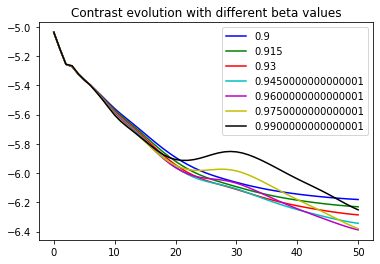

In [13]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for contrast, lcolor, betaval in zip(beta_contrasts, colors, betas):
    plt.plot(np.log10(contrast), color=lcolor, label=betaval)
    plt.legend(betas)

plt.title("Contrast evolution with different beta values")
plt.show()    

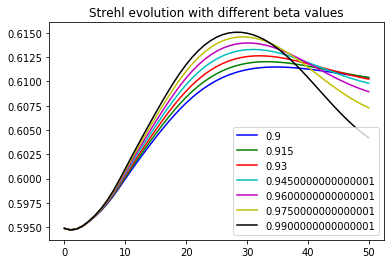

In [14]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for strehl, lcolor, betaval in zip(beta_strehls, colors, betas):
    plt.plot(strehl, color=lcolor, label=betaval)
    plt.legend(betas)

plt.title("Strehl evolution with different beta values")
plt.show()    

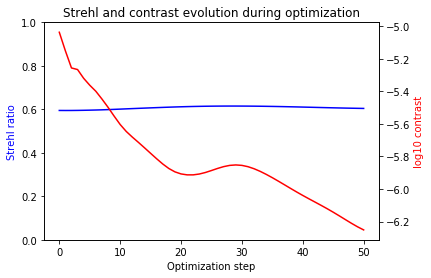

In [15]:
## Plot the strehl and contrast evolution
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(strehls, 'b')
ax2.plot(np.log10(contrasts), 'r')

ax1.set_xlabel('Optimization step')
ax1.set_ylabel('Strehl ratio', color='b')
ax1.set_ylim(0, 1)
ax2.set_ylabel('log10 contrast', color='r')

plt.title("Strehl and contrast evolution during optimization")
plt.show()

Text(0.5, 1.0, 'PSF contrast optimization\nStrehl=0.6042\nContrast= 5.6100E-07')

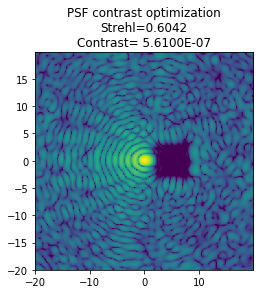

In [18]:
imshow_field(np.log10(instant_img / instant_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast optimization\nStrehl={0:.4f}\nContrast= {1:.4E}".format(instant_strehl, instant_contrast))

In [ ]:
plt.plot(dm2.actuators.copy(), 'b')

In [ ]:
gerch_sax_contrast_opt_acts = dm2.actuators.copy()
gerch_sax_contrast_opt_acts_masked = gerch_sax_contrast_opt_acts * mask * meters_to_rads

gerch_sax_img = prop(app.forward(dm2.forward(wfatms))).power
gerch_sax_strehl = gerch_sax_img[np.argmax(diff_lim_img)] / diff_lim_img.max()
gerch_sax_contrast = gerch_sax_img[dz_ind].mean() / gerch_sax_img[np.argmax(diff_lim_img)]

plt.subplot(1, 2, 1)
imshow_field(np.log10(flat_img / flat_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF WF flattening\nStrehl={0:.4f}\nContrast= {1:.4E}".format(flat_strehl, flat_contrast))
plt.subplot(1, 2, 2)
imshow_field(np.log10(gerch_sax_img / gerch_sax_img.max()), vmin=-6, grid=plot_grid)
plt.title("PSF contrast optimization\nStrehl={0:.4f}\nContrast= {1:.4E}".format(gerch_sax_strehl, gerch_sax_contrast))
plt.show()